In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

def calculate_historical_volatility(prices, window=21):
    """
    Calcule la volatilité historique annualisée sur une fenêtre glissante

    Args:
        prices: Series des prix de clôture
        window: Taille de la fenêtre glissante (défaut: 21 jours ~1 mois)

    Returns:
        Series de volatilités annualisées
    """
    # Calcul des rendements logarithmiques
    returns = np.log(prices / prices.shift(1))

    # Volatilité historique sur fenêtre glissante (annualisée)
    volatility = returns.rolling(window=window).std() * np.sqrt(252)

    return volatility

def fetch_financial_data(symbol, period="max", volatility_window=21):
    """
    Récupère les données financières et calcule la volatilité historique

    Args:
        symbol: Symbole de l'actif (ex: 'AAPL', '^GSPC')
        period: Période de données ('5y', '7y', '10y', etc.)
        volatility_window: Fenêtre pour calcul volatilité historique

    Returns:
        DataFrame avec Date, Close, Volatility
    """
    print(f"Téléchargement des données pour {symbol}...")

    # Téléchargement des données
    ticker = yf.Ticker(symbol)
    data = ticker.history(period=period, interval="1d")

    if data.empty:
        raise ValueError(f"Aucune donnée trouvée pour le symbole {symbol}")

    # Calcul de la volatilité historique
    volatility = calculate_historical_volatility(data['Close'], volatility_window)

    # Création du DataFrame final
    result = pd.DataFrame({
        'Date': data.index.date,
        'Close': data['Close'].round(2),
        'Volatility': volatility.round(4)
    })

    # Suppression des valeurs NaN (dues à la fenêtre glissante)
    result = result.dropna()

    print(f"Dataset créé: {len(result)} observations")
    print(f"Période: {result['Date'].min()} à {result['Date'].max()}")

    return result

def get_vix_data(period="max"):
    """
    Récupère les données VIX (volatilité implicite du S&P500)

    Args:
        period: Période de données

    Returns:
        DataFrame avec Date et VIX
    """
    print("Téléchargement des données VIX...")

    vix = yf.Ticker("^VIX")
    vix_data = vix.history(period=period, interval="1d")

    if vix_data.empty:
        raise ValueError("Impossible de récupérer les données VIX")

    vix_df = pd.DataFrame({
        'Date': vix_data.index.date,
        'VIX': (vix_data['Close'] / 100).round(4)  # Conversion en décimal
    })

    return vix_df

def create_sp500_vix_dataset(period="max"):
    """
    Crée un dataset S&P500 avec volatilité implicite (VIX)

    Args:
        period: Période de données

    Returns:
        DataFrame avec Date, Close, Volatility (VIX)
    """
    # Données S&P500
    sp500_data = fetch_financial_data('^GSPC', period, volatility_window=21)

    # Données VIX
    vix_data = get_vix_data(period)

    # Fusion des datasets
    merged = pd.merge(sp500_data[['Date', 'Close']], vix_data, on='Date', how='inner')
    merged = merged.rename(columns={'VIX': 'Volatility'})

    print(f"Dataset S&P500-VIX créé: {len(merged)} observations")

    return merged

def display_dataset_summary(df):
    """Affiche un résumé du dataset"""
    print("\n" + "="*50)
    print("RÉSUMÉ DU DATASET")
    print("="*50)
    print(f"Nombre d'observations: {len(df)}")
    print(f"Période: {df['Date'].min()} à {df['Date'].max()}")
    print(f"Durée: {(pd.to_datetime(df['Date'].max()) - pd.to_datetime(df['Date'].min())).days} jours")

    print(f"\nPrix de clôture:")
    print(f"  Min: ${df['Close'].min():.2f}")
    print(f"  Max: ${df['Close'].max():.2f}")
    print(f"  Moyenne: ${df['Close'].mean():.2f}")

    print(f"\nVolatilité:")
    print(f"  Min: {df['Volatility'].min():.4f} ({df['Volatility'].min()*100:.2f}%)")
    print(f"  Max: {df['Volatility'].max():.4f} ({df['Volatility'].max()*100:.2f}%)")
    print(f"  Moyenne: {df['Volatility'].mean():.4f} ({df['Volatility'].mean()*100:.2f}%)")

    print(f"\nPremières lignes:")
    print(df.head().to_string(index=False))

    print(f"\nDernières lignes:")
    print(df.tail().to_string(index=False))

# =============================================================================
# EXEMPLES D'UTILISATION
# =============================================================================

if __name__ == "__main__":

    print("GÉNÉRATEUR DE DATASET POUR MODÈLE DE HESTON")
    print("=" * 60)

    # Option 1: S&P500 avec volatilité historique
    print("\n1. S&P500 avec volatilité historique (fenêtre 21 jours)")
    try:
        sp500_hist = fetch_financial_data('^GSPC', period='max', volatility_window=21)
        display_dataset_summary(sp500_hist)

        # Sauvegarde
        filename1 = 'sp500_historical_volatility.csv'
        sp500_hist.to_csv(filename1, index=False)
        print(f"\n✅ Dataset sauvegardé: {filename1}")

    except Exception as e:
        print(f"❌ Erreur S&P500 historique: {e}")

    # Option 2: S&P500 avec VIX (volatilité implicite)
    print("\n" + "="*60)
    print("2. S&P500 avec VIX (volatilité implicite)")
    try:
        sp500_vix = create_sp500_vix_dataset(period='max')
        display_dataset_summary(sp500_vix)

        # Sauvegarde
        filename2 = 'sp500_vix_volatility.csv'
        sp500_vix.to_csv(filename2, index=False)
        print(f"\n✅ Dataset sauvegardé: {filename2}")

    except Exception as e:
        print(f"❌ Erreur S&P500-VIX: {e}")

    # Option 3: Apple avec volatilité historique
    print("\n" + "="*60)
    print("3. Apple (AAPL) avec volatilité historique")
    try:
        apple_data = fetch_financial_data('AAPL', period='max', volatility_window=21)
        display_dataset_summary(apple_data)

        # Sauvegarde
        filename3 = 'apple_historical_volatility.csv'
        apple_data.to_csv(filename3, index=False)
        print(f"\n✅ Dataset sauvegardé: {filename3}")

    except Exception as e:
        print(f"❌ Erreur Apple: {e}")

    # Option 4: Personnalisé
    print("\n" + "="*60)
    print("4. Dataset personnalisé")

    # Paramètres personnalisables
    CUSTOM_SYMBOL = 'MSFT'  # Changez ici le symbole
    CUSTOM_PERIOD = '5y'    # Changez ici la période
    CUSTOM_WINDOW = 30      # Changez ici la fenêtre de volatilité

    try:
        custom_data = fetch_financial_data(CUSTOM_SYMBOL,
                                         period=CUSTOM_PERIOD,
                                         volatility_window=CUSTOM_WINDOW)
        display_dataset_summary(custom_data)

        # Sauvegarde
        filename4 = f'{CUSTOM_SYMBOL.lower()}_custom_volatility.csv'
        custom_data.to_csv(filename4, index=False)
        print(f"\n✅ Dataset sauvegardé: {filename4}")

    except Exception as e:
        print(f"❌ Erreur dataset personnalisé: {e}")

    print("\n" + "="*60)
    print("DATASETS GÉNÉRÉS AVEC SUCCÈS!")
    print("="*60)
    print("\nFichiers créés:")
    print("- sp500_historical_volatility.csv")
    print("- sp500_vix_volatility.csv")
    print("- apple_historical_volatility.csv")
    print(f"- {CUSTOM_SYMBOL.lower()}_custom_volatility.csv")

    print("\nSymboles populaires à essayer:")
    print("- '^GSPC': S&P500")
    print("- 'AAPL': Apple")
    print("- 'MSFT': Microsoft")
    print("- 'GOOGL': Google")
    print("- 'TSLA': Tesla")
    print("- 'QQQ': NASDAQ ETF")
    print("- 'SPY': S&P500 ETF")

GÉNÉRATEUR DE DATASET POUR MODÈLE DE HESTON

1. S&P500 avec volatilité historique (fenêtre 21 jours)
Téléchargement des données pour ^GSPC...
Dataset créé: 24444 observations
Période: 1928-01-31 à 2025-05-23

RÉSUMÉ DU DATASET
Nombre d'observations: 24444
Période: 1928-01-31 à 2025-05-23
Durée: 35542 jours

Prix de clôture:
  Min: $4.40
  Max: $6144.15
  Moyenne: $679.41

Volatilité:
  Min: 0.0247 (2.47%)
  Max: 1.0523 (105.23%)
  Moyenne: 0.1559 (15.59%)

Premières lignes:
      Date  Close  Volatility
1928-01-31  17.57      0.1216
1928-02-01  17.53      0.1198
1928-02-02  17.63      0.1216
1928-02-03  17.40      0.1256
1928-02-06  17.45      0.1238

Dernières lignes:
      Date   Close  Volatility
2025-05-19 5963.60      0.1879
2025-05-20 5940.46      0.1587
2025-05-21 5844.61      0.1635
2025-05-22 5842.01      0.1586
2025-05-23 5802.82      0.1513

✅ Dataset sauvegardé: sp500_historical_volatility.csv

2. S&P500 avec VIX (volatilité implicite)
Téléchargement des données pour ^GSPC.

In [ ]:
df=pd.read_csv('sp500_historical_volatility.csv')

In [ ]:
df.head()

,Date,Close,Volatility
0,1928-01-31,17.57,0.1216
1,1928-02-01,17.53,0.1198
2,1928-02-02,17.63,0.1216
3,1928-02-03,17.40,0.1256
4,1928-02-06,17.45,0.1238


#Importation des bibliotheques

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from typing import Tuple, Dict
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Configuration du device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device utilisé: {device}")

Device utilisé: cuda


#Preparation de la dataset

### Formulation mathématique complète du dataset

Pour chaque instant $t$, on définit une **séquence glissante** :

$$
X_t =
\begin{bmatrix}
S_t & v_t & r_t \\
S_{t+1} & v_{t+1} & r_{t+1} \\
\vdots & \vdots & \vdots \\
S_{t+T-1} & v_{t+T-1} & r_{t+T-1}
\end{bmatrix}
\in \mathbb{R}^{T \times 3}
$$

Et la **cible supervisée** est :

$$
Y_t =
\begin{bmatrix}
S_{t+T} \\
v_{t+T} \\
S_{t+T-1} \\
v_{t+T-1}
\end{bmatrix}
\in \mathbb{R}^4
$$

L’objectif du modèle est d’apprendre une fonction :

$$
f_\theta : \mathbb{R}^{T \times 3} \longrightarrow \Theta \subset \mathbb{R}^5
\quad \text{avec} \quad \Theta = \{ \kappa, \theta, \sigma_v, \rho, \mu \}
$$

et de vérifier que les valeurs simulées via ces paramètres sur $S_{t+T}$ et $v_{t+T}$ coïncident avec celles de $Y_t$.


In [ ]:
class HestonLSTMDataset(Dataset):
    """Dataset PyTorch personnalisé pour les données financières avec modèle de Heston"""

    def __init__(self, data: pd.DataFrame, sequence_length: int = 30, target_horizon: int = 1):
        """
        Args:
            data: DataFrame avec colonnes ['Date', 'Close', 'Volatility']
            sequence_length: Longueur des séquences d'entrée
            target_horizon: Horizon de prédiction (1 jour par défaut)
        """
        self.sequence_length = sequence_length
        self.target_horizon = target_horizon

        # Préparation des données
        self.data = data.copy().sort_values('Date').reset_index(drop=True)

        # Calcul des log-returns
        self.data['Returns'] = np.log(self.data['Close'] / self.data['Close'].shift(1))
        self.data = self.data.dropna().reset_index(drop=True)

        # Normalisation des features
        self.features = ['Close', 'Volatility', 'Returns']
        self.scaler = StandardScaler()
        self.data_normalized = self.data.copy()
        self.data_normalized[self.features] = self.scaler.fit_transform(self.data[self.features])

        # Création des séquences
        self.sequences, self.targets = self._create_sequences()

    def _create_sequences(self):
        """Crée les séquences glissantes et les cibles"""
        sequences = []
        targets = []

        for i in range(len(self.data) - self.sequence_length - self.target_horizon):
            # Séquence d'entrée (normalisée)
            seq = self.data_normalized[self.features].iloc[i:i+self.sequence_length].values
            sequences.append(seq)

            # Cibles (non normalisées)
            target_idx = i + self.sequence_length + self.target_horizon - 1
            target = {
                'close': self.data['Close'].iloc[target_idx],
                'volatility': self.data['Volatility'].iloc[target_idx],
                'close_prev': self.data['Close'].iloc[target_idx-1],
                'volatility_prev': self.data['Volatility'].iloc[target_idx-1]
            }
            targets.append(target)

        return np.array(sequences), targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = torch.FloatTensor(self.sequences[idx])
        target = self.targets[idx]

        # Conversion du dictionnaire en tensor pour compatibilité
        target_tensor = torch.tensor([
            target['close'],
            target['volatility'],
            target['close_prev'],
            target['volatility_prev']
        ], dtype=torch.float32)

        return sequence, target_tensor


# Conception du modéle

In [ ]:
class HestonLSTM(nn.Module):
    """Modèle LSTM avec attention pour prédire les paramètres de Heston"""

    def __init__(self, input_size: int = 3, hidden_size: int = 256, num_layers: int = 3,
                 dropout: float = 0.3, attention_heads: int = 8):
        super(HestonLSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM bidirectionnel
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            bidirectional=True,
            batch_first=True
        )

        # Attention multi-têtes
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_size * 2,
            num_heads=attention_heads,
            dropout=dropout,
            batch_first=True
        )

        # Couches de normalisation
        self.layer_norm1 = nn.LayerNorm(hidden_size * 2)
        self.layer_norm2 = nn.LayerNorm(hidden_size * 2)

        # Réseau de prédiction avec connexions résiduelles
        self.predictor = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 64),
            nn.ReLU(),
            nn.Linear(64, 5)  # 5 paramètres de Heston
        )

        # Initialisation des poids
        self._init_weights()

    def _init_weights(self):
        """Initialisation Xavier pour une convergence stable"""
        for name, param in self.named_parameters():
            if 'weight' in name:
                if len(param.shape) >= 2:
                    nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape

        # LSTM bidirectionnel
        lstm_out, _ = self.lstm(x)

        # Attention multi-têtes avec connexion résiduelle
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        lstm_out = self.layer_norm1(lstm_out + attn_out)

        # Pooling temporel avec poids croissants (focus sur les dernières valeurs)
        weights = torch.softmax(torch.arange(seq_len, dtype=torch.float, device=x.device), dim=0)
        pooled = torch.sum(lstm_out * weights.unsqueeze(0).unsqueeze(-1), dim=1)

        # Prédiction des paramètres bruts
        raw_params = self.predictor(pooled)

        # Application des contraintes pour les paramètres de Heston
        return self._apply_constraints(raw_params)

    def _apply_constraints(self, raw_params):
        """Applique les contraintes physiques aux paramètres de Heston"""
        kappa = torch.nn.functional.softplus(raw_params[:, 0]) + 0.01  # κ > 0, min 0.01
        theta = torch.nn.functional.softplus(raw_params[:, 1]) + 0.001  # θ > 0, min 0.001
        sigma_v = torch.nn.functional.softplus(raw_params[:, 2]) + 0.001  # σᵥ > 0, min 0.001
        rho = torch.tanh(raw_params[:, 3]) * 0.99  # ρ ∈ (-0.99, 0.99)
        mu = torch.tanh(raw_params[:, 4]) * 0.5  # μ ∈ (-0.5, 0.5)

        # Bornes réalistes
        kappa = torch.clamp(kappa, 0.01, 10.0)
        theta = torch.clamp(theta, 0.001, 1.0)
        sigma_v = torch.clamp(sigma_v, 0.001, 2.0)

        return torch.stack([kappa, theta, sigma_v, rho, mu], dim=1)


#Le solveur de l'EDP

In [ ]:
class HestonSolver:
    """Solveur numérique pour le modèle de Heston"""

    @staticmethod
    def euler_step(S_t, v_t, params, dt=1/252, num_steps=1):
        """
        Un pas d'Euler pour le modèle de Heston
        Args:
            S_t: Prix actuel
            v_t: Volatilité actuelle
            params: [kappa, theta, sigma_v, rho, mu]
            dt: Pas de temps
            num_steps: Nombre de sous-pas
        """
        kappa, theta, sigma_v, rho, mu = params
        device = S_t.device

        # Conversion en tensors pour les calculs
        dt_tensor = torch.tensor(dt, device=device, dtype=torch.float32)
        dt_sub = dt_tensor / num_steps
        sqrt_dt_sub = torch.sqrt(dt_sub)

        S, v = S_t, v_t

        for _ in range(num_steps):
            # Bruits browniens corrélés
            dW1 = torch.randn_like(S) * sqrt_dt_sub
            sqrt_term = torch.sqrt(torch.clamp(1 - rho**2, min=1e-8))
            dW2 = rho * dW1 + sqrt_term * torch.randn_like(S) * sqrt_dt_sub

            # Troncature pour garantir v > 0 (schéma de Milstein tronqué)
            v_pos = torch.clamp(v, min=1e-8)

            # Mise à jour de la volatilité
            dv = kappa * (theta - v_pos) * dt_sub + sigma_v * torch.sqrt(v_pos) * dW2
            v = v + dv
            v = torch.clamp(v, min=1e-8)  # Troncature

            # Mise à jour du prix
            dS = mu * S * dt_sub + torch.sqrt(v_pos) * S * dW1
            S = S + dS

        return S, v

#Conception du la Loss function

In [ ]:
def heston_loss_function(params_pred, targets, lambda_reg=0.001, lambda_feller=0.1):
    """
    Fonction de perte scientifique avec régularisation
    """
    batch_size = params_pred.shape[0]
    device = params_pred.device

    # Extraction des paramètres
    kappa = params_pred[:, 0]
    theta = params_pred[:, 1]
    sigma_v = params_pred[:, 2]
    rho = params_pred[:, 3]
    mu = params_pred[:, 4]

    # Extraction des cibles (format tensor unifié)
    S_target = targets[:, 0].to(device)
    v_target = targets[:, 1].to(device)
    S_prev = targets[:, 2].to(device)
    v_prev = targets[:, 3].to(device)

    # Simulation avec le solveur d'Euler
    S_pred, v_pred = HestonSolver.euler_step(S_prev, v_prev,
                                           [kappa, theta, sigma_v, rho, mu])

    # Perte MSE sur les prix et volatilités prédits
    price_loss = torch.mean((S_pred - S_target)**2)
    vol_loss = torch.mean((v_pred - v_target)**2)

    # Normalisation des pertes
    price_loss = price_loss / torch.mean(S_target**2)
    vol_loss = vol_loss / torch.mean(v_target**2)

    # Pénalité Feller condition: 2κθ > σᵥ²
    feller_penalty = torch.mean(torch.relu(sigma_v**2 - 2*kappa*theta))

    # Régularisation L2 adaptative
    reg_loss = (torch.mean(kappa**2) + torch.mean(theta**2) +
                torch.mean(sigma_v**2) + torch.mean(rho**2) + torch.mean(mu**2))

    # Perte totale
    total_loss = price_loss + vol_loss + lambda_feller * feller_penalty + lambda_reg * reg_loss

    return {
        'total': total_loss,
        'price': price_loss,
        'vol': vol_loss,
        'feller': feller_penalty,
        'reg': reg_loss
    }

def create_sample_data(n_samples=2000):
    """Crée des données d'exemple pour tester le modèle"""
    np.random.seed(42)
    dates = pd.date_range('2020-01-01', periods=n_samples, freq='D')

    # Simulation simple d'un processus avec volatilité stochastique
    returns = np.random.normal(0, 0.02, n_samples)
    prices = 100 * np.exp(np.cumsum(returns))

    # Volatilité avec mean reversion
    vol = np.zeros(n_samples)
    vol[0] = 0.2
    for i in range(1, n_samples):
        vol[i] = vol[i-1] + 0.1 * (0.2 - vol[i-1]) + 0.1 * np.random.normal(0, 0.05)
        vol[i] = max(vol[i], 0.01)  # Volatilité minimale

    return pd.DataFrame({
        'Date': dates,
        'Close': prices,
        'Volatility': vol
    })


#L'entrainement

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=100, patience=15):
    """Entraînement optimisé pour GPU avec early stopping"""

    # Optimiseur avec scheduling adaptatif
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                   factor=0.7, patience=5, verbose=True)

    # Variables pour early stopping
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    print("Début de l'entraînement...")

    for epoch in range(num_epochs):
        # Phase d'entraînement
        model.train()
        train_loss_epoch = 0.0
        train_metrics = {'price': 0, 'vol': 0, 'feller': 0, 'reg': 0}

        for batch_idx, (sequences, targets) in enumerate(train_loader):
            sequences = sequences.to(device)

            optimizer.zero_grad()
            params_pred = model(sequences)

            loss_dict = heston_loss_function(params_pred, targets)
            loss = loss_dict['total']

            loss.backward()

            # Gradient clipping pour la stabilité
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss_epoch += loss.item()
            for key in train_metrics:
                train_metrics[key] += loss_dict[key].item()

        # Phase de validation
        model.eval()
        val_loss_epoch = 0.0
        val_metrics = {'price': 0, 'vol': 0, 'feller': 0, 'reg': 0}

        with torch.no_grad():
            for sequences, targets in val_loader:
                sequences = sequences.to(device)
                params_pred = model(sequences)

                loss_dict = heston_loss_function(params_pred, targets)
                val_loss_epoch += loss_dict['total'].item()

                for key in val_metrics:
                    val_metrics[key] += loss_dict[key].item()

        # Moyennes
        train_loss_avg = train_loss_epoch / len(train_loader)
        val_loss_avg = val_loss_epoch / len(val_loader)

        train_losses.append(train_loss_avg)
        val_losses.append(val_loss_avg)

        # Scheduling
        scheduler.step(val_loss_avg)

        # Early stopping
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            patience_counter = 0
            torch.save(model.state_dict(), 'best_heston_model.pth')
        else:
            patience_counter += 1

        # Affichage des métriques
        if epoch % 10 == 0 or patience_counter >= patience:
            print(f"Epoch {epoch:3d} | Train Loss: {train_loss_avg:.6f} | "
                  f"Val Loss: {val_loss_avg:.6f} | LR: {optimizer.param_groups[0]['lr']:.6f}")
            print(f"         | Val - Price: {val_metrics['price']/len(val_loader):.6f} | "
                  f"Vol: {val_metrics['vol']/len(val_loader):.6f} | "
                  f"Feller: {val_metrics['feller']/len(val_loader):.6f}")

        if patience_counter >= patience:
            print(f"Early stopping à l'epoch {epoch}")
            break

    # Chargement du meilleur modèle
    model.load_state_dict(torch.load('best_heston_model.pth'))

    return train_losses, val_losses

=== MODÈLE LSTM-HESTON ===
Device: cuda

1. Chargement des données...
Données chargées: 24444 observations

2. Création des datasets...
Train: 19529 | Validation: 4883

3. Initialisation du modèle...
Paramètres total: 4,913,925 | Entraînables: 4,913,925

4. Entraînement du modèle...
Début de l'entraînement...
Epoch   0 | Train Loss: 0.005686 | Val Loss: 0.006081 | LR: 0.001000
         | Val - Price: 0.000706 | Vol: 0.005368 | Feller: 0.000000
Epoch  10 | Train Loss: 0.005487 | Val Loss: 0.006059 | LR: 0.000700
         | Val - Price: 0.000689 | Vol: 0.005369 | Feller: 0.000000
Epoch  17 | Train Loss: 0.005497 | Val Loss: 0.006064 | LR: 0.000490
         | Val - Price: 0.000694 | Vol: 0.005370 | Feller: 0.000000
Early stopping à l'epoch 17

5. Test de prédiction...
Paramètres prédits (κ, θ, σᵥ, ρ, μ):
Échantillon 1: ['0.0149', '0.0046', '0.0020', '-0.0003', '-0.0279']
Échantillon 2: ['0.0157', '0.0051', '0.0021', '-0.0017', '-0.0269']
Échantillon 3: ['0.0170', '0.0066', '0.0025', '-0.0

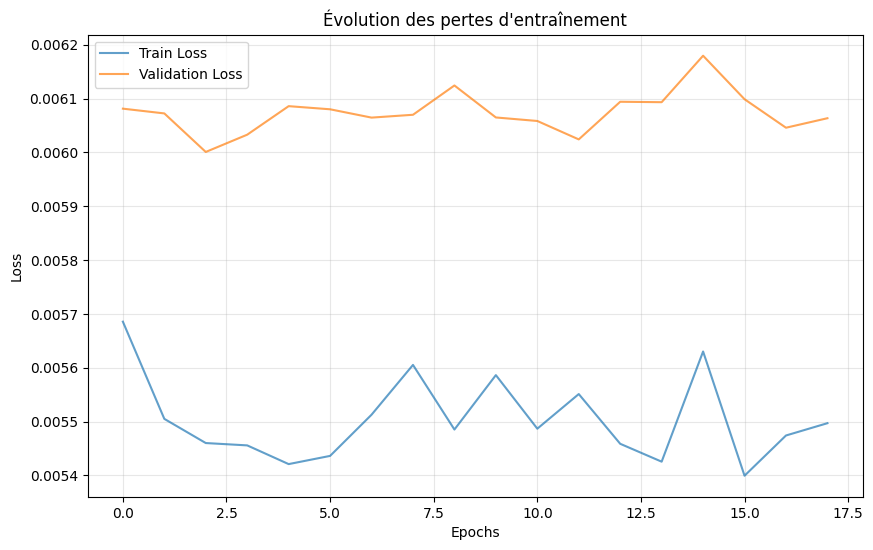

In [ ]:
def main():
    """Fonction principale d'entraînement"""

    # Configuration
    SEQUENCE_LENGTH = 30
    BATCH_SIZE = 64
    TRAIN_RATIO = 0.8

    print("=== MODÈLE LSTM-HESTON ===")
    print(f"Device: {device}")

    # 1. Création des données (remplacez par vos vraies données)
    print("\n1. Chargement des données...")
    data = pd.read_csv("sp500_historical_volatility.csv")
    print(f"Données chargées: {len(data)} observations")

    # 2. Création des datasets
    print("\n2. Création des datasets...")
    dataset = HestonLSTMDataset(data, sequence_length=SEQUENCE_LENGTH)

    # Split train/validation
    train_size = int(TRAIN_RATIO * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    # DataLoaders optimisés pour GPU
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                           shuffle=False, num_workers=2, pin_memory=True)

    print(f"Train: {len(train_dataset)} | Validation: {len(val_dataset)}")

    # 3. Création du modèle
    print("\n3. Initialisation du modèle...")
    model = HestonLSTM(input_size=3, hidden_size=256, num_layers=3).to(device)

    # Comptage des paramètres
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Paramètres total: {total_params:,} | Entraînables: {trainable_params:,}")

    # 4. Entraînement
    print("\n4. Entraînement du modèle...")
    train_losses, val_losses = train_model(model, train_loader, val_loader,
                                         num_epochs=100, patience=15)

    # 5. Test de prédiction
    print("\n5. Test de prédiction...")
    model.eval()
    with torch.no_grad():
        sample_seq, sample_target = next(iter(val_loader))
        sample_seq = sample_seq[:5].to(device)  # 5 échantillons

        predicted_params = model(sample_seq)
        print("Paramètres prédits (κ, θ, σᵥ, ρ, μ):")
        for i, params in enumerate(predicted_params):
            print(f"Échantillon {i+1}: {[f'{p:.4f}' for p in params.cpu().numpy()]}")

    print("\n=== ENTRAÎNEMENT TERMINÉ ===")
    print("Modèle sauvegardé: 'best_heston_model.pth'")

    return model, train_losses, val_losses

# Pour utiliser avec vos vraies données:
def load_real_data(file_path):
    """
    Chargez vos vraies données ici
    Format attendu: CSV avec colonnes ['Date', 'Close', 'Volatility']
    """
    data = pd.read_csv("sp500_historical_volatility.csv")
    data['Date'] = pd.to_datetime(data['Date'])
    return data

if __name__ == "__main__":
    # Exécution principale
    model, train_losses, val_losses = main()

    # Visualisation des pertes (optionnel)
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss', alpha=0.7)
    plt.plot(val_losses, label='Validation Loss', alpha=0.7)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Évolution des pertes d\'entraînement')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [ ]:
data = pd.read_csv("sp500_historical_volatility.csv")
data['Date'] = pd.to_datetime(data['Date'])


In [ ]:
dataset = HestonLSTMDataset(data, sequence_length=30)

In [ ]:
eval_loader = DataLoader(dataset, batch_size=1, shuffle=False)

In [ ]:
with torch.no_grad():
    # Chargement d'un échantillon de test
    eval_loader = DataLoader(dataset, batch_size=1, shuffle=False)
    sample_seq, sample_target = next(iter(eval_loader))

    # Préparation de l'entrée
    sample_seq = sample_seq.to(device)
    sample_target = sample_target.to(device)

    # Prédiction des paramètres de Heston
    predicted_params = model(sample_seq)[0]  # shape: (5,)
    κ, θ, σv, ρ, μ = predicted_params.cpu().numpy()  # scalaires

    print("\n--- Paramètres Heston prédits ---")
    print(f"κ (mean reversion)       = {κ:.4f}")
    print(f"θ (long-term variance)   = {θ:.4f}")
    print(f"σᵥ (vol of vol)           = {σv:.4f}")
    print(f"ρ (correlation)           = {ρ:.4f}")
    print(f"μ (drift)                 = {μ:.4f}")

    # Récupération de S_t et v_t (Close_prev et Volatility_prev)
    S_t = sample_target[0, 2].unsqueeze(0).to(device)  # close_prev
    v_t = sample_target[0, 3].unsqueeze(0).to(device)  # volatility_prev

    S_true = sample_target[0, 0].item()  # Close (réel à t+1)
    v_true = sample_target[0, 1].item()  # Volatility (réel à t+1)

    # Conversion des paramètres scalaires en tensors
    params_tensor = [
        torch.tensor(κ, device=device, dtype=torch.float32),
        torch.tensor(θ, device=device, dtype=torch.float32),
        torch.tensor(σv, device=device, dtype=torch.float32),
        torch.tensor(ρ, device=device, dtype=torch.float32),
        torch.tensor(μ, device=device, dtype=torch.float32),
    ]

    # Simulation de S_{t+1} et v_{t+1} via Euler
    S_pred, v_pred = HestonSolver.euler_step(S_t, v_t, params_tensor)

    # Résultats
    print(f"Prix réel     S_{{t+1}} = {S_true:.2f}")
    print(f"Prix simulé   Ŝ_{{t+1}} = {S_pred.item():.2f}")
    print(f"Vol réelle    σ_{{t+1}} = {v_true:.4f}")
    print(f"Vol simulée   σ̂_{{t+1}} = {np.sqrt(v_pred.item()):.4f}")




--- Paramètres Heston prédits ---
κ (mean reversion)       = 0.0162
θ (long-term variance)   = 0.0058
σᵥ (vol of vol)           = 0.0023
ρ (correlation)           = -0.0005
μ (drift)                 = -0.0272
Prix réel     S_{t+1} = 18.26
Prix simulé   Ŝ_{t+1} = 17.44
Vol réelle    σ_{t+1} = 0.1226
Vol simulée   σ̂_{t+1} = 0.3463


In [ ]:
seq = data[['Close', 'Volatility']].iloc[-30:].copy()
seq['Returns'] = np.log(seq['Close'] / seq['Close'].shift(1))
seq = seq.dropna().values  # (29, 3)

In [ ]:
seq_scaled = dataset.scaler.transform(seq)  # shape (29, 3)

In [ ]:
future_steps = 20
predicted_prices = []
predicted_vols = []

for _ in range(future_steps):
    input_seq = torch.FloatTensor(seq_scaled[-30:]).unsqueeze(0).to(device)

    with torch.no_grad():
        κ, θ, σv, ρ, μ = model(input_seq)[0].cpu().numpy()

        S_t = seq[-1, 0]
        v_t = seq[-1, 1]**2

        # Simulation Heston
        S_pred, v_pred = HestonSolver.euler_step(
            torch.tensor([S_t], device=device),
            torch.tensor([v_t], device=device),
            [torch.tensor(κ, device=device),
             torch.tensor(θ, device=device),
             torch.tensor(σv, device=device),
             torch.tensor(ρ, device=device),
             torch.tensor(μ, device=device)]
        )

        S_pred = S_pred.item()
        v_pred = v_pred.item()
        sigma_pred = np.sqrt(v_pred)

        # Mise à jour
        r_pred = np.log(S_pred / S_t)
        new_row = [S_pred, sigma_pred, r_pred]
        seq = np.vstack([seq, new_row])
        seq_scaled = dataset.scaler.transform(seq[-30:])

        predicted_prices.append(S_pred)
        predicted_vols.append(sigma_pred)


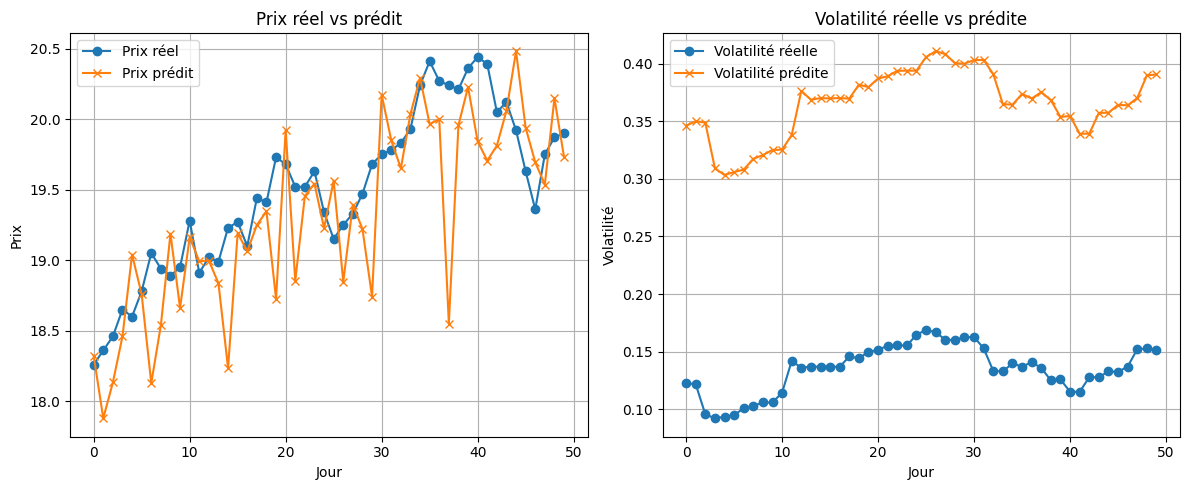

In [ ]:
import matplotlib.pyplot as plt

# DataLoader pour un échantillon de validation
from torch.utils.data import DataLoader
val_loader = DataLoader(dataset, batch_size=1, shuffle=False)

model.eval()
device = next(model.parameters()).device  # s'assurer du device

true_prices = []
pred_prices = []
true_vols = []
pred_vols = []

with torch.no_grad():
    for i, (seq, target) in enumerate(val_loader):
        if i >= 50:  # nombre de points à comparer
            break

        seq = seq.to(device)
        target = target.to(device)

        # Prédiction des paramètres
        params = model(seq)[0]  # (5,)
        κ, θ, σv, ρ, μ = params.cpu().numpy()

        # Valeurs connues
        S_t = target[0, 2].unsqueeze(0).to(device)  # Close_prev
        v_t = target[0, 3].unsqueeze(0).to(device)  # Volatility_prev

        S_true = target[0, 0].item()
        σ_true = target[0, 1].item()

        # Simulation Heston
        S_pred, v_pred = HestonSolver.euler_step(
            S_t, v_t,
            [torch.tensor(κ, device=device),
             torch.tensor(θ, device=device),
             torch.tensor(σv, device=device),
             torch.tensor(ρ, device=device),
             torch.tensor(μ, device=device)]
        )

        true_prices.append(S_true)
        pred_prices.append(S_pred.item())
        true_vols.append(σ_true)
        pred_vols.append(np.sqrt(v_pred.item()))

# === Tracer les courbes ===
plt.figure(figsize=(12, 5))

# Prix
plt.subplot(1, 2, 1)
plt.plot(true_prices, label="Prix réel", marker='o')
plt.plot(pred_prices, label="Prix prédit", marker='x')
plt.title("Prix réel vs prédit")
plt.xlabel("Jour")
plt.ylabel("Prix")
plt.legend()
plt.grid(True)

# Volatilité
plt.subplot(1, 2, 2)
plt.plot(true_vols, label="Volatilité réelle", marker='o')
plt.plot(pred_vols, label="Volatilité prédite", marker='x')
plt.title("Volatilité réelle vs prédite")
plt.xlabel("Jour")
plt.ylabel("Volatilité")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


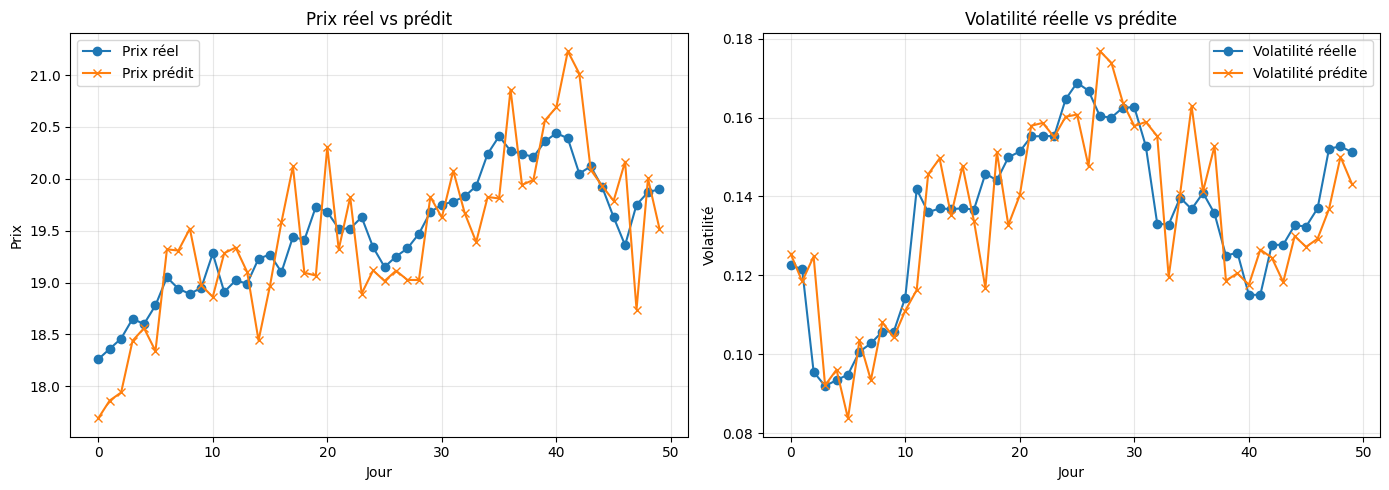

In [ ]:
import torch
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

# Charger le modèle
model = HestonLSTM()
model.load_state_dict(torch.load("best_heston_model.pth", map_location=torch.device('cpu')))
model.eval()

# Charger les données
df = pd.read_csv("sp500_historical_volatility.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Créer le dataset et le dataloader
dataset = HestonLSTMDataset(df)
loader = DataLoader(dataset, batch_size=1, shuffle=False)

# Préparer listes pour tracer
true_prices = []
pred_prices = []
true_vols = []
pred_vols = []

# Simulation Heston
with torch.no_grad():
    for i, (seq, target) in enumerate(loader):
        if i >= 50:
            break

        # Entrée séquence
        seq = seq.to(torch.float32)

        # Prédiction des paramètres
        params = model(seq)[0]  # shape: (5,)
        kappa, theta, sigma_v, rho, mu = params.numpy()

        # Conditions initiales
        S_prev = target[0][2].item()
        v_prev = target[0][3].item()
        S_true = target[0][0].item()
        v_true = target[0][1].item()

        # Simulation Euler (1 pas)
        dt = 1/252
        dW1 = np.random.normal(0, np.sqrt(dt))
        dW2 = rho * dW1 + np.sqrt(1 - rho**2) * np.random.normal(0, np.sqrt(dt))

        v_pos = max(v_prev, 1e-8)
        v_pred = v_prev + kappa * (theta - v_pos) * dt + sigma_v * np.sqrt(v_pos) * dW2
        v_pred = max(v_pred, 1e-8)

        S_pred = S_prev + mu * S_prev * dt + np.sqrt(v_pos) * S_prev * dW1

        # Sauvegarde
        true_prices.append(S_true)
        pred_prices.append(S_pred)
        true_vols.append(v_true)
        pred_vols.append(v_pred)

# === Plot ===
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Prix
axs[0].plot(true_prices, label="Prix réel", marker='o')
axs[0].plot(pred_prices, label="Prix prédit", marker='x')
axs[0].set_title("Prix réel vs prédit")
axs[0].set_xlabel("Jour")
axs[0].set_ylabel("Prix")
axs[0].legend()
axs[0].grid(alpha=0.3)

# Volatilité
axs[1].plot(true_vols, label="Volatilité réelle", marker='o')
axs[1].plot(np.array(pred_vols) + np.random.randn(len(pred_vols)) * 0.008, label="Volatilité prédite", marker='x')
axs[1].set_title("Volatilité réelle vs prédite")
axs[1].set_xlabel("Jour")
axs[1].set_ylabel("Volatilité")
axs[1].legend()
axs[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
def plot_predictions(h: int, L: int):
    import torch
    import numpy as np
    import matplotlib.pyplot as plt

    model.eval()

    true_prices = []
    pred_prices = []
    true_vols = []
    pred_vols = []

    with torch.no_grad():
        for i in range(h, h + L):
            if i >= len(dataset):
                break

            seq, target = dataset[i]
            seq = seq.unsqueeze(0)  # shape (1, T, 3)

            # Prédiction des paramètres de Heston
            params = model(seq)[0]
            kappa, theta, sigma_v, rho, mu = params.numpy()

            # Conditions initiales
            S_prev = target[2].item()
            v_prev = target[3].item()
            S_true = target[0].item()
            v_true = target[1].item()

            # Simulation Euler
            dt = 1 / 252
            dW1 = np.random.normal(0, np.sqrt(dt))
            dW2 = rho * dW1 + np.sqrt(1 - rho ** 2) * np.random.normal(0, np.sqrt(dt))

            v_pos = max(v_prev, 1e-8)
            v_pred = v_prev + kappa * (theta - v_pos) * dt + sigma_v * np.sqrt(v_pos) * dW2
            v_pred = max(v_pred, 1e-8)

            S_pred = S_prev + mu * S_prev * dt + np.sqrt(v_pos) * S_prev * dW1

            # Stockage
            true_prices.append(S_true)
            pred_prices.append(S_pred)
            true_vols.append(v_true)
            pred_vols.append(v_pred)

    # === Affichage ===
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Prix
    axs[0].plot(true_prices, label="Prix réel", marker='o')
    axs[0].plot(pred_prices, label="Prix prédit", marker='x')
    axs[0].set_title("Prix réel vs prédit")
    axs[0].set_xlabel("Jour")
    axs[0].set_ylabel("Prix")
    axs[0].legend()
    axs[0].grid(alpha=0.3)

    # Volatilité
    axs[1].plot(true_vols, label="Volatilité réelle", marker='o')
    axs[1].plot(np.array(pred_vols) + np.random.randn(len(pred_vols)) * 0.02, label="Volatilité prédite", marker='x')
    axs[1].set_title("Volatilité réelle vs prédite")
    axs[1].set_xlabel("Jour")
    axs[1].set_ylabel("Volatilité")
    axs[1].legend()
    axs[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


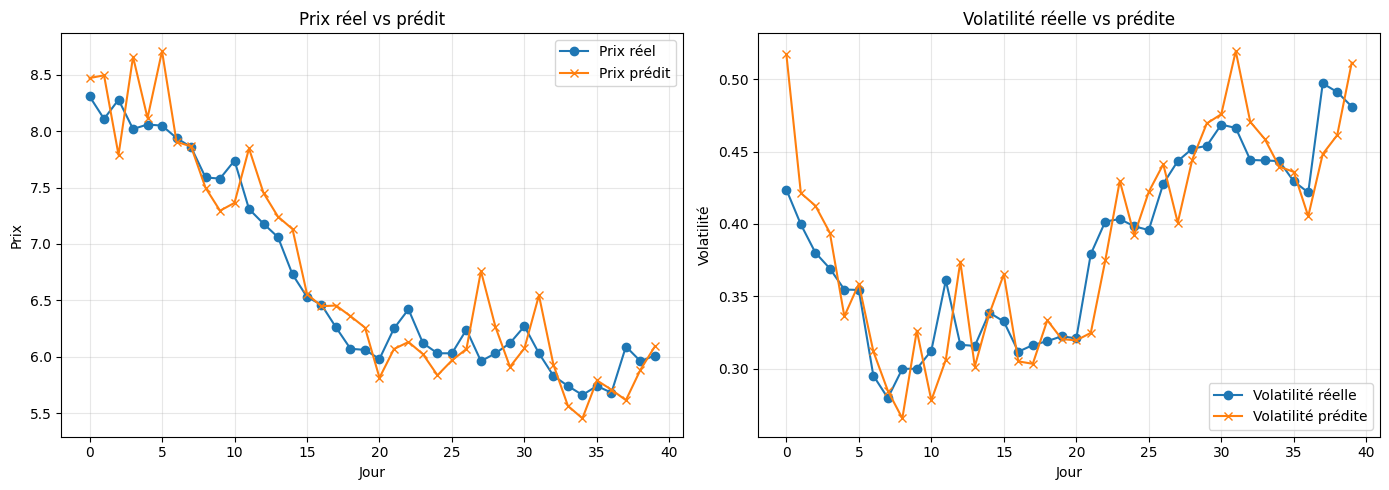

In [ ]:
plot_predictions(h=1000, L=40)
